# Feature engineering

## Open-rate
open_rate = “What % of potential store-days were actually open this week?”

### 1. load both datasets and peek

In [1]:
import pandas as pd
weekly_sales= pd.read_csv("../data/processed/weekly_sales_v1.csv")
daily_sales_kaggle= pd.read_csv("../data/raw/train.csv")
weekly_sales.head()


/var/folders/jn/dc5313mj0qs72qr08qqw3w3r0000gn/T/ipykernel_86533/1107802266.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  daily_sales_kaggle= pd.read_csv("../data/raw/train.csv")


,Date,Sales,Promo,Year,Month,Week_num,trend,StateHoliday,SchoolHoliday,Digital_spend,CPM,Digital_impressions,CTR,Digital_clicks,LandingRate,Product_page_views,TV_spend,OOH_spend
0,2013-01-06,26129335,0.000000,2013,1,1,1,1,0.740103,71476.013153,6.108456,1.170116e+07,0.009486,111002.906731,0.496163,55075.497241,0.0,0.0
1,2013-01-13,49275222,0.831102,2013,1,2,2,0,0.083471,78186.218005,6.657182,1.174464e+07,0.012347,145011.371049,0.504316,73131.526628,0.0,0.0
2,2013-01-20,34377765,0.000000,2013,1,3,3,0,0.000000,81560.325505,5.848056,1.394657e+07,0.007442,103783.699864,0.411973,42756.078058,0.0,0.0
3,2013-01-27,46040169,0.830758,2013,1,4,4,0,0.000000,114601.069498,5.604729,2.044721e+07,0.009471,193648.184854,0.449691,87081.888730,0.0,0.0
4,2013-02-03,38466029,0.000000,2013,2,5,5,0,0.019199,70428.442099,5.811603,1.211859e+07,0.010723,129948.869713,0.465507,60492.137175,0.0,0.0


In [2]:
daily_sales_kaggle.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [3]:
print(f"Weekly sales columns: {weekly_sales.columns}")
print(weekly_sales.dtypes)
print(f"daily sales columns: {daily_sales_kaggle.columns}")
print(daily_sales_kaggle.dtypes)

Weekly sales columns: Index(['Date', 'Sales', 'Promo', 'Year', 'Month', 'Week_num', 'trend',
       'StateHoliday', 'SchoolHoliday', 'Digital_spend', 'CPM',
       'Digital_impressions', 'CTR', 'Digital_clicks', 'LandingRate',
       'Product_page_views', 'TV_spend', 'OOH_spend'],
      dtype='object')
Date                    object
Sales                    int64
Promo                  float64
Year                     int64
Month                    int64
Week_num                 int64
trend                    int64
StateHoliday             int64
SchoolHoliday          float64
Digital_spend          float64
CPM                    float64
Digital_impressions    float64
CTR                    float64
Digital_clicks         float64
LandingRate            float64
Product_page_views     float64
TV_spend               float64
OOH_spend              float64
dtype: object
daily sales columns: Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'Sch

In [4]:
# convert to datetime
weekly_sales["Date"]= pd.to_datetime(weekly_sales["Date"], errors="coerce")
weekly_sales["weekday"] = weekly_sales["Date"].dt.dayofweek
weekly_sales[["Date","weekday","Week_num"]]

,Date,weekday,Week_num
0,2013-01-06,6,1
1,2013-01-13,6,2
2,2013-01-20,6,3
3,2013-01-27,6,4
4,2013-02-03,6,5
...,...,...,...
130,2015-07-05,6,27
131,2015-07-12,6,28
132,2015-07-19,6,29
133,2015-07-26,6,30


Now we have to convert daily sales date to datetime and add week start column for later merge with weekly_sales

In [5]:
# kaggle dataset datetime
daily_sales_kaggle["Date"]= pd.to_datetime(daily_sales_kaggle["Date"], errors="coerce")
daily_sales_kaggle["week_start"]= daily_sales_kaggle["Date"].dt.to_period("W-SUN")
daily_sales_kaggle["week_start"] = daily_sales_kaggle["week_start"].dt.to_timestamp()
daily_sales_kaggle["week_day_start"] = daily_sales_kaggle["week_start"].dt.dayofweek

daily_sales_kaggle.sort_values("Date")[["Store","Date","week_start","Open","week_day_start"]].head(10)

,Store,Date,week_start,Open,week_day_start
1017208,1115,2013-01-01,2012-12-31,0,0
1016473,379,2013-01-01,2012-12-31,0,0
1016472,378,2013-01-01,2012-12-31,0,0
1016471,377,2013-01-01,2012-12-31,0,0
1016470,376,2013-01-01,2012-12-31,0,0
1016469,375,2013-01-01,2012-12-31,0,0
1016468,374,2013-01-01,2012-12-31,0,0
1016467,373,2013-01-01,2012-12-31,0,0
1016466,372,2013-01-01,2012-12-31,0,0
1016465,371,2013-01-01,2012-12-31,0,0


In [6]:
# A1) Shift the weekly label to the Sunday that ends the week
daily_sales_kaggle["week_end"] = daily_sales_kaggle["week_start"] + pd.Timedelta(days=6)

# A2) Sanity check: Sunday == 6
daily_sales_kaggle["week_end_dow"] = daily_sales_kaggle["week_end"].dt.dayofweek
daily_sales_kaggle.sort_values("Date")[["Store","Date","week_end","week_end_dow","Open"]].head(8)

,Store,Date,week_end,week_end_dow,Open
1017208,1115,2013-01-01,2013-01-06,6,0
1016473,379,2013-01-01,2013-01-06,6,0
1016472,378,2013-01-01,2013-01-06,6,0
1016471,377,2013-01-01,2013-01-06,6,0
1016470,376,2013-01-01,2013-01-06,6,0
1016469,375,2013-01-01,2013-01-06,6,0
1016468,374,2013-01-01,2013-01-06,6,0
1016467,373,2013-01-01,2013-01-06,6,0


In [7]:
# B1) Unique Sundays in each
wk_sundays = set(pd.to_datetime(weekly_sales["Date"]).unique())
dl_sundays = set(daily_sales_kaggle["week_end"].unique())

# B2) Intersection size
len_wk = len(wk_sundays)
len_dl = len(dl_sundays)
len_inter = len(wk_sundays & dl_sundays)
(len_wk, len_dl, len_inter)


(135, 135, 135)

every row in the Kaggle dataset now correctly points to Sunday, exactly like the weekly_sales table
### Compute open rate 
1. For each store, how many days that week were they open?

In [8]:
store_open= daily_sales_kaggle.groupby(["Store", "week_end"])["Open"].sum().reset_index(name="open_days")
store_open.head()


,Store,week_end,open_days
0,1,2013-01-06,4
1,1,2013-01-13,6
2,1,2013-01-20,6
3,1,2013-01-27,6
4,1,2013-02-03,6


2. Open rate per store

In [9]:
store_open["open_rate_store"]= store_open["open_days"]/7
store_open.head()

,Store,week_end,open_days,open_rate_store
0,1,2013-01-06,4,0.571429
1,1,2013-01-13,6,0.857143
2,1,2013-01-20,6,0.857143
3,1,2013-01-27,6,0.857143
4,1,2013-02-03,6,0.857143


3. Agg store week -> week-level

In [10]:
weekly_open_rate= store_open.groupby(pd.Grouper(key="week_end", freq="W"))["open_rate_store"].mean().reset_index()
weekly_open_rate.head()

,week_end,open_rate_store
0,2013-01-06,0.572838
1,2013-01-13,0.851890
2,2013-01-20,0.852530
3,2013-01-27,0.853940
4,2013-02-03,0.854196


4. Merge with weekly sales

In [11]:
weekly_sales_enriched = pd.merge(weekly_sales, weekly_open_rate, left_on='Date', right_on='week_end', how='inner')
weekly_sales_enriched.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 135 non-null    datetime64[ns]
 1   Sales                135 non-null    int64         
 2   Promo                135 non-null    float64       
 3   Year                 135 non-null    int64         
 4   Month                135 non-null    int64         
 5   Week_num             135 non-null    int64         
 6   trend                135 non-null    int64         
 7   StateHoliday         135 non-null    int64         
 8   SchoolHoliday        135 non-null    float64       
 9   Digital_spend        135 non-null    float64       
 10  CPM                  135 non-null    float64       
 11  Digital_impressions  135 non-null    float64       
 12  CTR                  135 non-null    float64       
 13  Digital_clicks       135 non-null  

In [12]:
weekly_sales_enriched.head()

,Date,Sales,Promo,Year,Month,Week_num,trend,StateHoliday,SchoolHoliday,Digital_spend,...,Digital_impressions,CTR,Digital_clicks,LandingRate,Product_page_views,TV_spend,OOH_spend,weekday,week_end,open_rate_store
0,2013-01-06,26129335,0.000000,2013,1,1,1,1,0.740103,71476.013153,...,1.170116e+07,0.009486,111002.906731,0.496163,55075.497241,0.0,0.0,6,2013-01-06,0.572838
1,2013-01-13,49275222,0.831102,2013,1,2,2,0,0.083471,78186.218005,...,1.174464e+07,0.012347,145011.371049,0.504316,73131.526628,0.0,0.0,6,2013-01-13,0.851890
2,2013-01-20,34377765,0.000000,2013,1,3,3,0,0.000000,81560.325505,...,1.394657e+07,0.007442,103783.699864,0.411973,42756.078058,0.0,0.0,6,2013-01-20,0.852530
3,2013-01-27,46040169,0.830758,2013,1,4,4,0,0.000000,114601.069498,...,2.044721e+07,0.009471,193648.184854,0.449691,87081.888730,0.0,0.0,6,2013-01-27,0.853940
4,2013-02-03,38466029,0.000000,2013,2,5,5,0,0.019199,70428.442099,...,1.211859e+07,0.010723,129948.869713,0.465507,60492.137175,0.0,0.0,6,2013-02-03,0.854196


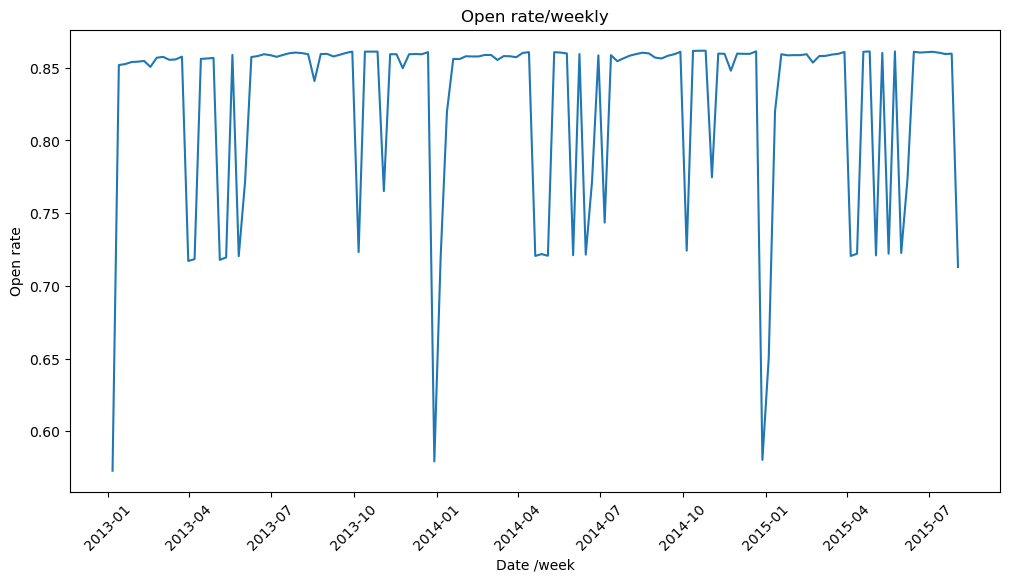

In [13]:
import matplotlib.pyplot as plt

# Data 
x= weekly_sales_enriched["Date"]
y= weekly_sales_enriched["open_rate_store"]

# Plot
plt.figure(figsize=(12,6))
plt.plot(x,y)

#Labels

plt.xlabel("Date /week")
plt.ylabel("Open rate")
plt.title("Open rate/weekly")
plt.xticks(rotation=45)

plt.show()

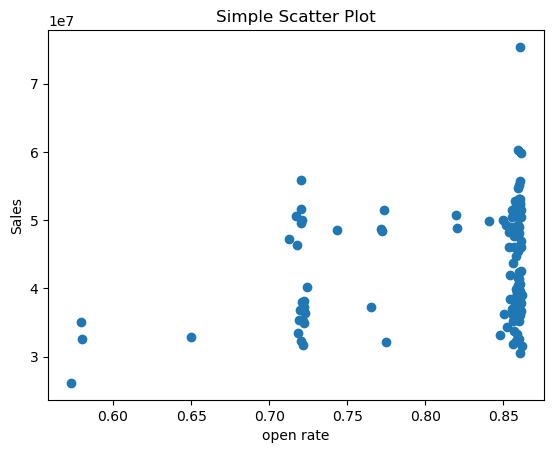

In [14]:
# Visualize correlation between sales and promos 
# Example data
x = weekly_sales_enriched["open_rate_store"]
y = weekly_sales_enriched["Sales"]

# Create scatter plot
plt.scatter(x, y)

# Add labels and title
plt.xlabel("open rate")
plt.ylabel("Sales")
plt.title("Simple Scatter Plot")

# Show the plot
plt.show()

## Promotions 

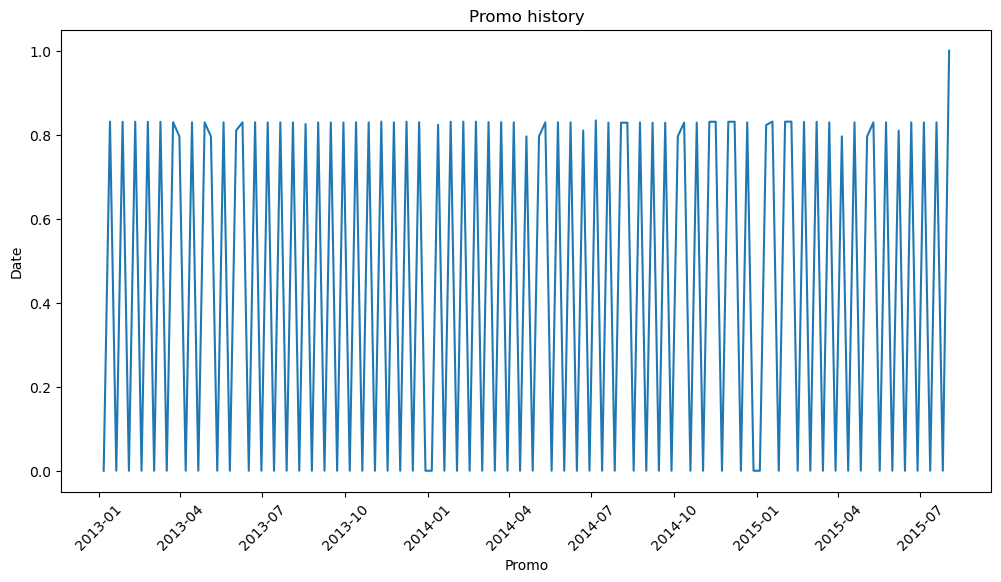

In [15]:
# promo exploration 
x= weekly_sales_enriched["Date"]
y= weekly_sales_enriched["Promo"]

plt.figure(figsize=(12,6))
plt.plot(x,y)

#Labels

plt.xlabel("Promo")
plt.ylabel("Date")
plt.title("Promo history")
plt.xticks(rotation=45)
plt.show()

Replacing the simple binary Promo variable with richer engineered features can significantly improve the model’s interpretability and predictive power, if done carefully.

In [16]:
weekly_sales_enriched.columns

Index(['Date', 'Sales', 'Promo', 'Year', 'Month', 'Week_num', 'trend',
       'StateHoliday', 'SchoolHoliday', 'Digital_spend', 'CPM',
       'Digital_impressions', 'CTR', 'Digital_clicks', 'LandingRate',
       'Product_page_views', 'TV_spend', 'OOH_spend', 'weekday', 'week_end',
       'open_rate_store'],
      dtype='object')

1. Understand and quantify the sales effect of Promo

In [17]:
weekly_sales_enriched["Promo"].describe()

count    135.000000
mean       0.441560
std        0.414921
min        0.000000
25%        0.000000
50%        0.796089
75%        0.829403
max        1.000000
Name: Promo, dtype: float64

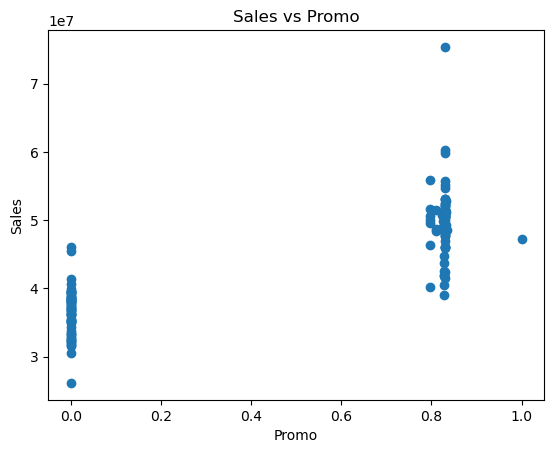

In [18]:
x= weekly_sales_enriched["Promo"]
y = weekly_sales_enriched["Sales"]

plt.scatter(x,y)
plt.xlabel("Promo")
plt.ylabel("Sales")
plt.title("Sales vs Promo")


plt.show()

In [19]:
corr_pearson  = weekly_sales_enriched["Sales"].corr(weekly_sales_enriched["Promo"], method="pearson")
corr_spearman = weekly_sales_enriched["Sales"].corr(weekly_sales_enriched["Promo"], method="spearman")

print("Pearson r:", corr_pearson)
print("Spearman p:", corr_spearman)


Pearson r: 0.8296720998989091
Spearman p: 0.790643715292034


In [20]:
import numpy as np
x= weekly_sales_enriched["Promo"].values
y= weekly_sales_enriched["Sales"].values
slope, intercept = np.polyfit(x, y, 1)

delta_sales_per_01 = slope * 0.1  # effect of +10pp coverage
print("Slope (ΔSales per +1.0 in Promo):", slope)
print("ΔSales for +0.1 Promo:", delta_sales_per_01)


Slope (ΔSales per +1.0 in Promo): 15718486.961155334
ΔSales for +0.1 Promo: 1571848.6961155336


If promo coverage increased from 0 to 1 (0% → 100%), weekly sales would be expected to rise by ≈ 15.7 million units of currency.

So every +0.1 (10 percentage-point) increase in coverage adds roughly +1.57 million in weekly sales.

That’s a big, consistent effect.

In [21]:
sales_mean = weekly_sales_enriched["Sales"].mean()
promo_mean = weekly_sales_enriched["Promo"].mean()

elasticity_at_mean = slope * (promo_mean / sales_mean)
print("Elasticity at mean:", elasticity_at_mean)


Elasticity at mean: 0.15953671197946812


A 1% increase in promo coverage is associated with a 0.16% increase in weekly sales.

### Promo intensity
Convert the observed relationship between Promo (coverage) and Sales into a new feature, promo_intensity, that reflects how powerful the promotion was in that week.
- It converts “promotion happened” → “promotion strength that week”.
- It preserves the meaning of Promo but adds magnitude.
- It helps MMM detect not just presence but effect variation across weeks.

In [22]:
import statsmodels.api as sm

df= weekly_sales_enriched.copy()
nonpromo = df[df["Promo"] < 0.05]  # consider ~0 coverage as no promo
X = sm.add_constant(nonpromo[["trend", "Month"]])
y = nonpromo["Sales"]

model = sm.OLS(y, X).fit()

# Predict baseline for all weeks
df["baseline_sales"] = model.predict(sm.add_constant(df[["trend", "Month"]]))
df.head()


,Date,Sales,Promo,Year,Month,Week_num,trend,StateHoliday,SchoolHoliday,Digital_spend,...,CTR,Digital_clicks,LandingRate,Product_page_views,TV_spend,OOH_spend,weekday,week_end,open_rate_store,baseline_sales
0,2013-01-06,26129335,0.000000,2013,1,1,1,1,0.740103,71476.013153,...,0.009486,111002.906731,0.496163,55075.497241,0.0,0.0,6,2013-01-06,0.572838,3.584752e+07
1,2013-01-13,49275222,0.831102,2013,1,2,2,0,0.083471,78186.218005,...,0.012347,145011.371049,0.504316,73131.526628,0.0,0.0,6,2013-01-13,0.851890,3.585626e+07
2,2013-01-20,34377765,0.000000,2013,1,3,3,0,0.000000,81560.325505,...,0.007442,103783.699864,0.411973,42756.078058,0.0,0.0,6,2013-01-20,0.852530,3.586500e+07
3,2013-01-27,46040169,0.830758,2013,1,4,4,0,0.000000,114601.069498,...,0.009471,193648.184854,0.449691,87081.888730,0.0,0.0,6,2013-01-27,0.853940,3.587375e+07
4,2013-02-03,38466029,0.000000,2013,2,5,5,0,0.019199,70428.442099,...,0.010723,129948.869713,0.465507,60492.137175,0.0,0.0,6,2013-02-03,0.854196,3.590751e+07


In [23]:
df["lift_pct"] = (df["Sales"] - df["baseline_sales"]) / df["baseline_sales"]
df["promo_intensity"] = df["Promo"] * df["lift_pct"]

df[["Date","Sales","trend","Month", "Promo", "baseline_sales","lift_pct","promo_intensity"]].head(10)

,Date,Sales,trend,Month,Promo,baseline_sales,lift_pct,promo_intensity
0,2013-01-06,26129335,1,1,0.000000,3.584752e+07,-0.271098,-0.000000
1,2013-01-13,49275222,2,1,0.831102,3.585626e+07,0.374243,0.311034
2,2013-01-20,34377765,3,1,0.000000,3.586500e+07,-0.041468,-0.000000
3,2013-01-27,46040169,4,1,0.830758,3.587375e+07,0.283395,0.235432
4,2013-02-03,38466029,5,2,0.000000,3.590751e+07,0.071253,0.000000
5,2013-02-10,49002283,6,2,0.831060,3.591625e+07,0.364349,0.302795
6,2013-02-17,36269664,7,2,0.000000,3.592499e+07,0.009594,0.000000
7,2013-02-24,47701937,8,2,0.830742,3.593374e+07,0.327497,0.272066
8,2013-03-03,38622888,9,3,0.000000,3.596750e+07,0.073827,0.000000
9,2013-03-10,50405423,10,3,0.830762,3.597624e+07,0.401075,0.333198


| Column            | Meaning                                                  | Example interpretation                            |
| ----------------- | -------------------------------------------------------- | ------------------------------------------------- |
| `Sales`           | Actual weekly sales (real data)                          | What really happened that week                    |
| `trend` / `Month` | Inputs used for baseline                                 | Represent long-term growth and seasonality        |
| `Promo`           | Promo coverage (share of stores running promo that week) | 0 → no promo, 0.83 → ~83% of stores in promo      |
| `baseline_sales`  | Expected sales if no promotion had happened              | From your regression using non-promo weeks        |
| `lift_pct`        | % difference between actual and baseline sales           | Positive = sales above expected; negative = below |
| `promo_intensity` | Effective promo strength = coverage × lift               | Combines reach and impact into one value          |


### Promo type

set promo type =None when promo=0

| Intensity range | Type label   |
| --------------- | ------------ |
| `≤ 0.26`        | `"discount"`  |
| `0.26 – 0.30`   | `"chelas"` |
| `0.30 – 0.34`   | `"caguamas"`   |
| `> 0.34`        | `"flash"`    |


#### Option 1

In [24]:
promo_mask = df["Promo"] > 0
x = df.loc[promo_mask, "promo_intensity"].to_numpy()

conditions = [
    (x <= 0.26),
    (x > 0.26) & (x <= 0.30),
    (x > 0.30) & (x <= 0.34),
    (x > 0.34)
]
choices = ["discount", "chelas", "caguamas", "flash"]

df["promo_type"] = "Unassigned"
df.loc[~promo_mask, "promo_type"] = "None"
df.loc[promo_mask, "promo_type"] = np.select(conditions, choices, default="unknown")

In [25]:
df["promo_type"].value_counts()

promo_type
None        63
caguamas    19
discount    19
flash       18
chelas      16
Name: count, dtype: int64

#### Option 2

In [26]:
df["Promo"].describe()

count    135.000000
mean       0.441560
std        0.414921
min        0.000000
25%        0.000000
50%        0.796089
75%        0.829403
max        1.000000
Name: Promo, dtype: float64

In [27]:
promo_mask = df["Promo"] > 0
x = df.loc[promo_mask, "Promo"].to_numpy()  #  use coverage instead of intensity

conditions = [
    (x < 0.7),
    (x >= 0.7)
]

choices = ["chelas", "caguamas"]

df["promo_type2"] = "Unassigned"
df.loc[~promo_mask, "promo_type2"] = "None"
df.loc[promo_mask, "promo_type2"] = np.select(conditions, choices, default="unknown")

In [28]:
df.columns

Index(['Date', 'Sales', 'Promo', 'Year', 'Month', 'Week_num', 'trend',
       'StateHoliday', 'SchoolHoliday', 'Digital_spend', 'CPM',
       'Digital_impressions', 'CTR', 'Digital_clicks', 'LandingRate',
       'Product_page_views', 'TV_spend', 'OOH_spend', 'weekday', 'week_end',
       'open_rate_store', 'baseline_sales', 'lift_pct', 'promo_intensity',
       'promo_type', 'promo_type2'],
      dtype='object')

In [29]:
df["promo_type2"].value_counts()

promo_type2
caguamas    72
None        63
Name: count, dtype: int64

🚨‼️ problem

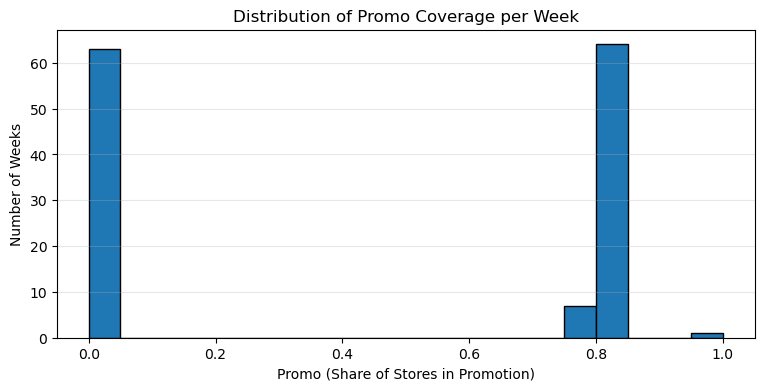

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,4))
plt.hist(df["Promo"], bins=20, edgecolor='black')
plt.title("Distribution of Promo Coverage per Week")
plt.xlabel("Promo (Share of Stores in Promotion)")
plt.ylabel("Number of Weeks")
plt.grid(axis='y', alpha=0.3)
plt.show()


merge into weekly_sales_enriched

In [31]:
cols_to_add= ["baseline_sales", "lift_pct", "promo_intensity", "promo_type","promo_type2"]

weekly_sales_enriched = pd.merge(
    weekly_sales_enriched,
    df[["Date"] + cols_to_add],  # select only the key + desired columns
    on="Date",                    # column that exists in both DataFrames
    how="inner"                          # type of join: 'left', 'right', 'inner', 'outer'
)

weekly_sales_enriched.head()

,Date,Sales,Promo,Year,Month,Week_num,trend,StateHoliday,SchoolHoliday,Digital_spend,...,TV_spend,OOH_spend,weekday,week_end,open_rate_store,baseline_sales,lift_pct,promo_intensity,promo_type,promo_type2
0,2013-01-06,26129335,0.000000,2013,1,1,1,1,0.740103,71476.013153,...,0.0,0.0,6,2013-01-06,0.572838,3.584752e+07,-0.271098,-0.000000,None,None
1,2013-01-13,49275222,0.831102,2013,1,2,2,0,0.083471,78186.218005,...,0.0,0.0,6,2013-01-13,0.851890,3.585626e+07,0.374243,0.311034,caguamas,caguamas
2,2013-01-20,34377765,0.000000,2013,1,3,3,0,0.000000,81560.325505,...,0.0,0.0,6,2013-01-20,0.852530,3.586500e+07,-0.041468,-0.000000,None,None
3,2013-01-27,46040169,0.830758,2013,1,4,4,0,0.000000,114601.069498,...,0.0,0.0,6,2013-01-27,0.853940,3.587375e+07,0.283395,0.235432,discount,caguamas
4,2013-02-03,38466029,0.000000,2013,2,5,5,0,0.019199,70428.442099,...,0.0,0.0,6,2013-02-03,0.854196,3.590751e+07,0.071253,0.000000,None,None


In [32]:
weekly_sales_enriched.head()


,Date,Sales,Promo,Year,Month,Week_num,trend,StateHoliday,SchoolHoliday,Digital_spend,...,TV_spend,OOH_spend,weekday,week_end,open_rate_store,baseline_sales,lift_pct,promo_intensity,promo_type,promo_type2
0,2013-01-06,26129335,0.000000,2013,1,1,1,1,0.740103,71476.013153,...,0.0,0.0,6,2013-01-06,0.572838,3.584752e+07,-0.271098,-0.000000,None,None
1,2013-01-13,49275222,0.831102,2013,1,2,2,0,0.083471,78186.218005,...,0.0,0.0,6,2013-01-13,0.851890,3.585626e+07,0.374243,0.311034,caguamas,caguamas
2,2013-01-20,34377765,0.000000,2013,1,3,3,0,0.000000,81560.325505,...,0.0,0.0,6,2013-01-20,0.852530,3.586500e+07,-0.041468,-0.000000,None,None
3,2013-01-27,46040169,0.830758,2013,1,4,4,0,0.000000,114601.069498,...,0.0,0.0,6,2013-01-27,0.853940,3.587375e+07,0.283395,0.235432,discount,caguamas
4,2013-02-03,38466029,0.000000,2013,2,5,5,0,0.019199,70428.442099,...,0.0,0.0,6,2013-02-03,0.854196,3.590751e+07,0.071253,0.000000,None,None


In [33]:
print(weekly_sales_enriched["baseline_sales"].info())
print(weekly_sales_enriched["baseline_sales"].describe())

<class 'pandas.core.series.Series'>
RangeIndex: 135 entries, 0 to 134
Series name: baseline_sales
Non-Null Count  Dtype  
--------------  -----  
135 non-null    float64
dtypes: float64(1)
memory usage: 1.2 KB
None
count    1.350000e+02
mean     3.655839e+07
std      3.609394e+05
min      3.584752e+07
25%      3.630666e+07
50%      3.655113e+07
75%      3.687690e+07
max      3.719421e+07
Name: baseline_sales, dtype: float64


Each promo type has roughly the same number of weeks (no tiny or overrepresented bucket).

Around 70–80% of weeks are non-promo, which is perfect for MMM (we need enough baseline data to estimate incremental effects).

### Promo decay(Adstock, Carry over)

In [34]:
import sys, os
sys.path.append(os.path.abspath(".."))   # notebooks/ -> project root
from src.adstock import adstock

df = weekly_sales_enriched.sort_values("Date").copy()

lam = 0.5  # start here; test others later
df["promo_decay"] = adstock(df["promo_intensity"].fillna(0), lam)
df["promo_adstock"] = adstock(df["Promo"].fillna(0), lam)

#Normalization
mx = df["promo_decay"].max()
if mx > 0:
    df["promo_decay_norm"] = df["promo_decay"] / mx

mx2 = df["promo_adstock"].max()
df["promo_adstock_norm"] = df["promo_adstock"] / mx2

df[["Date","promo_intensity","promo_decay"]].head(10)




,Date,promo_intensity,promo_decay
0,2013-01-06,-0.000000,-0.000000
1,2013-01-13,0.311034,0.311034
2,2013-01-20,-0.000000,0.155517
3,2013-01-27,0.235432,0.313191
4,2013-02-03,0.000000,0.156595
5,2013-02-10,0.302795,0.381093
6,2013-02-17,0.000000,0.190547
7,2013-02-24,0.272066,0.367339
8,2013-03-03,0.000000,0.183669
9,2013-03-10,0.333198,0.425033


In [35]:
print(df["Sales"].corr(df["promo_decay"]))
print(df["Sales"].corr(df["promo_adstock_norm"]))

0.9021907816259813
0.7835795787944695


What this means
1. promo_decay = “cheating” variable
- You built it from promo_intensity, which already used Sales in its formula.
- So it contains part of the answer (Sales itself) → artificially high correlation.
- Looks “perfect” but not usable in regression, because it’s not an independent input.

2. promo_adstock_norm = “clean” marketing driver
- Built purely from Promo (the share of stores with promo each week).
- Doesn’t use Sales, so it’s exogenous → it tells the model what happened in marketing, not what happened in revenue.
- The correlation (≈ 0.78) is still strong — meaning promotions clearly affect sales — but now the relationship is real, not baked in.

merge into main df

In [36]:
cols_to_add= ["promo_decay", "promo_adstock_norm"]

weekly_sales_enriched = pd.merge(
    weekly_sales_enriched,
    df[["Date"] + cols_to_add],  # select only the key + desired columns
    on="Date",                    # column that exists in both DataFrames
    how="inner"                          # type of join: 'left', 'right', 'inner', 'outer'
)

weekly_sales_enriched.head()

,Date,Sales,Promo,Year,Month,Week_num,trend,StateHoliday,SchoolHoliday,Digital_spend,...,weekday,week_end,open_rate_store,baseline_sales,lift_pct,promo_intensity,promo_type,promo_type2,promo_decay,promo_adstock_norm
0,2013-01-06,26129335,0.000000,2013,1,1,1,1,0.740103,71476.013153,...,6,2013-01-06,0.572838,3.584752e+07,-0.271098,-0.000000,None,None,-0.000000,0.000000
1,2013-01-13,49275222,0.831102,2013,1,2,2,0,0.083471,78186.218005,...,6,2013-01-13,0.851890,3.585626e+07,0.374243,0.311034,caguamas,caguamas,0.311034,0.585096
2,2013-01-20,34377765,0.000000,2013,1,3,3,0,0.000000,81560.325505,...,6,2013-01-20,0.852530,3.586500e+07,-0.041468,-0.000000,None,None,0.155517,0.292548
3,2013-01-27,46040169,0.830758,2013,1,4,4,0,0.000000,114601.069498,...,6,2013-01-27,0.853940,3.587375e+07,0.283395,0.235432,discount,caguamas,0.313191,0.731127
4,2013-02-03,38466029,0.000000,2013,2,5,5,0,0.019199,70428.442099,...,6,2013-02-03,0.854196,3.590751e+07,0.071253,0.000000,None,None,0.156595,0.365564


# Colllinearity check

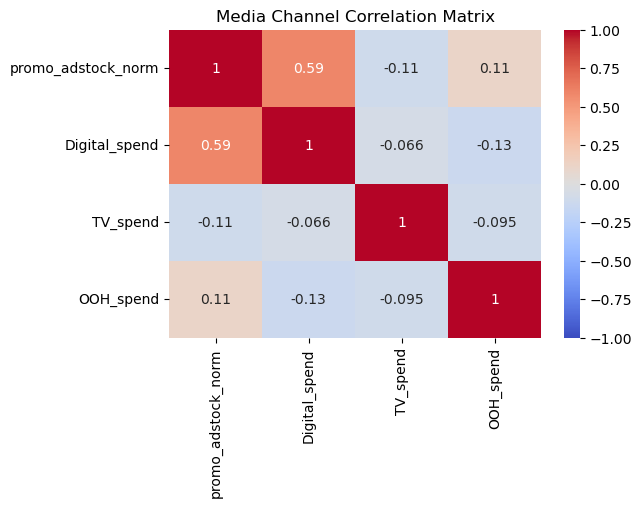

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select your main media variables
media_vars = ["promo_adstock_norm", "Digital_spend", "TV_spend", "OOH_spend"]

# Compute correlation matrix
corr =weekly_sales_enriched[media_vars].corr()

# Plot
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Media Channel Correlation Matrix")
plt.show()


No values above 0.8, so no collinearity problems — the model will be statistically stable.

We have a good mix of independent channels, meaning the regression can tell which one truly drives Sales.

Only slight overlap between Promo and Digital, which is common because digital campaigns often support promotions (this is normal in MMM).

🚨‼️ one hot encoding de la promo

## Holidays One-Hot Encoder

StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None


In [38]:
daily_sales_kaggle.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'week_start', 'week_day_start',
       'week_end', 'week_end_dow'],
      dtype='object')

In [39]:
weekly_sales_enriched["StateHoliday"].value_counts()

StateHoliday
0    105
1     30
Name: count, dtype: int64

In [40]:
daily_sales_kaggle["StateHoliday"].value_counts()

StateHoliday
0    855087
0    131072
a     20260
b      6690
c      4100
Name: count, dtype: int64

In [41]:
daily_sales_kaggle["SchoolHoliday"].value_counts()

SchoolHoliday
0    835488
1    181721
Name: count, dtype: int64

1. Normalizar dtypes

In [42]:
daily_sales_kaggle["StateHoliday"] = (
    daily_sales_kaggle["StateHoliday"]
    .astype(str)             # convierte todo a string
    .str.lower()             # por si acaso hay mayúsculas
    .replace({"0": "0"})     # unifica posibles '0' extraños
)
daily_sales_kaggle["StateHoliday"].value_counts()

StateHoliday
0    986159
a     20260
b      6690
c      4100
Name: count, dtype: int64

2. Get dummies

In [43]:
tmp = daily_sales_kaggle[["Date", "week_end", "StateHoliday"]].copy()
dummies = pd.get_dummies(tmp["StateHoliday"], prefix="holiday")

# mantener solo a, b, c
cols_keep = [c for c in dummies.columns if c in ["holiday_a", "holiday_b", "holiday_c"]]
tmp = pd.concat([tmp[["week_end"]], dummies[cols_keep]], axis=1)

# presencia semanal (0/1)
weekly_holidays = tmp.groupby("week_end", as_index=False).max()

weekly_holidays.head()

,week_end,holiday_a,holiday_b,holiday_c
0,2013-01-06,True,False,False
1,2013-01-13,False,False,False
2,2013-01-20,False,False,False
3,2013-01-27,False,False,False
4,2013-02-03,False,False,False


In [44]:

# merge con weekly_sales
# weekly_sales_enriched = weekly_sales_enriched.merge(weekly_holidays, on="week_end", how="left").fillna(0)

cols_to_add= ["holiday_a", "holiday_b", "holiday_c"]
weekly_holidays[cols_to_add] = weekly_holidays[cols_to_add].astype(int)


weekly_sales_enriched = pd.merge(
    weekly_sales_enriched,
    weekly_holidays[["week_end"] + cols_to_add],  # select only the key + desired columns
    on="week_end",               # column that exists in both DataFrames
    how="left"                          # type of join: 'left', 'right', 'inner', 'outer'
)

weekly_sales_enriched.head(10)


,Date,Sales,Promo,Year,Month,Week_num,trend,StateHoliday,SchoolHoliday,Digital_spend,...,baseline_sales,lift_pct,promo_intensity,promo_type,promo_type2,promo_decay,promo_adstock_norm,holiday_a,holiday_b,holiday_c
0,2013-01-06,26129335,0.000000,2013,1,1,1,1,0.740103,71476.013153,...,3.584752e+07,-0.271098,-0.000000,None,None,-0.000000,0.000000,1,0,0
1,2013-01-13,49275222,0.831102,2013,1,2,2,0,0.083471,78186.218005,...,3.585626e+07,0.374243,0.311034,caguamas,caguamas,0.311034,0.585096,0,0,0
2,2013-01-20,34377765,0.000000,2013,1,3,3,0,0.000000,81560.325505,...,3.586500e+07,-0.041468,-0.000000,None,None,0.155517,0.292548,0,0,0
3,2013-01-27,46040169,0.830758,2013,1,4,4,0,0.000000,114601.069498,...,3.587375e+07,0.283395,0.235432,discount,caguamas,0.313191,0.731127,0,0,0
4,2013-02-03,38466029,0.000000,2013,2,5,5,0,0.019199,70428.442099,...,3.590751e+07,0.071253,0.000000,None,None,0.156595,0.365564,0,0,0
5,2013-02-10,49002283,0.831060,2013,2,6,6,0,0.164143,83333.566119,...,3.591625e+07,0.364349,0.302795,caguamas,caguamas,0.381093,0.767848,0,0,0
6,2013-02-17,36269664,0.000000,2013,2,7,7,0,0.192047,63879.563915,...,3.592499e+07,0.009594,0.000000,None,None,0.190547,0.383924,0,0,0
7,2013-02-24,47701937,0.830742,2013,2,8,8,0,0.026914,64526.121634,...,3.593374e+07,0.327497,0.272066,chelas,caguamas,0.367339,0.776804,0,0,0
8,2013-03-03,38622888,0.000000,2013,3,9,9,0,0.000000,71753.223630,...,3.596750e+07,0.073827,0.000000,None,None,0.183669,0.388402,0,0,0
9,2013-03-10,50405423,0.830762,2013,3,10,10,0,0.020968,76750.044546,...,3.597624e+07,0.401075,0.333198,caguamas,caguamas,0.425033,0.779058,0,0,0


In [45]:
weekly_sales_enriched[["holiday_a", "holiday_b", "holiday_c"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   holiday_a  135 non-null    int64
 1   holiday_b  135 non-null    int64
 2   holiday_c  135 non-null    int64
dtypes: int64(3)
memory usage: 3.3 KB


In [46]:
weekly_sales_enriched[["holiday_a", "holiday_b", "holiday_c"]].value_counts()

holiday_a  holiday_b  holiday_c
0          0          0            103
1          0          0             24
0          1          0              6
           0          1              2
Name: count, dtype: int64

In [47]:
# 1) Ver que coincida con el total de semanas
weekly_sales_enriched.shape[0], weekly_sales_enriched[["holiday_a","holiday_b","holiday_c"]].value_counts().sum()


(135, np.int64(135))

In [48]:

# 2) Confirmar que no hay semanas con múltiples tipos
weekly_sales_enriched[["holiday_a","holiday_b","holiday_c"]].sum(axis=1).value_counts()


0    103
1     32
Name: count, dtype: int64

In [49]:

# 3) Tasas de activación
weekly_sales_enriched[["holiday_a","holiday_b","holiday_c"]].mean()

holiday_a    0.177778
holiday_b    0.044444
holiday_c    0.014815
dtype: float64

# Export enriched dataset

In [50]:
weekly_sales_enriched.columns.tolist()

['Date',
 'Sales',
 'Promo',
 'Year',
 'Month',
 'Week_num',
 'trend',
 'StateHoliday',
 'SchoolHoliday',
 'Digital_spend',
 'CPM',
 'Digital_impressions',
 'CTR',
 'Digital_clicks',
 'LandingRate',
 'Product_page_views',
 'TV_spend',
 'OOH_spend',
 'weekday',
 'week_end',
 'open_rate_store',
 'baseline_sales',
 'lift_pct',
 'promo_intensity',
 'promo_type',
 'promo_type2',
 'promo_decay',
 'promo_adstock_norm',
 'holiday_a',
 'holiday_b',
 'holiday_c']

In [51]:
cols_order = [
    # Identifiers
    "Date", "Year", "Month", "Week_num", "weekday", "trend",

    # Target variable
    "Sales", "baseline_sales", "lift_pct",

    # Store operations / context
    "open_rate_store", "StateHoliday", "SchoolHoliday",

    # Promotions
    "Promo", "promo_type", "promo_type2", "promo_intensity",
    "promo_decay", "promo_adstock_norm",

    # Marketing channels
    "Digital_spend", "TV_spend", "OOH_spend",

    # Digital funnel KPIs
    "CPM", "Digital_impressions", "CTR", "Digital_clicks",
    "LandingRate", "Product_page_views",

    # Holidays (exogenous shocks)
    "holiday_a", "holiday_b", "holiday_c"
]

# Reorder DataFrame
weekly_sales_enriched = weekly_sales_enriched[cols_order]

# Quick check
weekly_sales_enriched.head()


,Date,Year,Month,Week_num,weekday,trend,Sales,baseline_sales,lift_pct,open_rate_store,...,OOH_spend,CPM,Digital_impressions,CTR,Digital_clicks,LandingRate,Product_page_views,holiday_a,holiday_b,holiday_c
0,2013-01-06,2013,1,1,6,1,26129335,3.584752e+07,-0.271098,0.572838,...,0.0,6.108456,1.170116e+07,0.009486,111002.906731,0.496163,55075.497241,1,0,0
1,2013-01-13,2013,1,2,6,2,49275222,3.585626e+07,0.374243,0.851890,...,0.0,6.657182,1.174464e+07,0.012347,145011.371049,0.504316,73131.526628,0,0,0
2,2013-01-20,2013,1,3,6,3,34377765,3.586500e+07,-0.041468,0.852530,...,0.0,5.848056,1.394657e+07,0.007442,103783.699864,0.411973,42756.078058,0,0,0
3,2013-01-27,2013,1,4,6,4,46040169,3.587375e+07,0.283395,0.853940,...,0.0,5.604729,2.044721e+07,0.009471,193648.184854,0.449691,87081.888730,0,0,0
4,2013-02-03,2013,2,5,6,5,38466029,3.590751e+07,0.071253,0.854196,...,0.0,5.811603,1.211859e+07,0.010723,129948.869713,0.465507,60492.137175,0,0,0


## Phase 2: Feature engineering

## Adstock 

Adstock represents the carryover or lagged effect of advertising, where the impact of an advertisement persists over multiple periods. For example, a customer may be influenced by an ad days or even weeks after its exposure, and adstock accounts for this delayed effect in the MMM model. The concept of adstock is especially useful for long-term brand-building campaigns and channels like TV and print, where impressions often result in lasting consumer awareness​​.


In [52]:
weekly_sales_adstock= weekly_sales_enriched.sort_values("Date").reset_index(drop=True)
weekly_sales_adstock.head()

,Date,Year,Month,Week_num,weekday,trend,Sales,baseline_sales,lift_pct,open_rate_store,...,OOH_spend,CPM,Digital_impressions,CTR,Digital_clicks,LandingRate,Product_page_views,holiday_a,holiday_b,holiday_c
0,2013-01-06,2013,1,1,6,1,26129335,3.584752e+07,-0.271098,0.572838,...,0.0,6.108456,1.170116e+07,0.009486,111002.906731,0.496163,55075.497241,1,0,0
1,2013-01-13,2013,1,2,6,2,49275222,3.585626e+07,0.374243,0.851890,...,0.0,6.657182,1.174464e+07,0.012347,145011.371049,0.504316,73131.526628,0,0,0
2,2013-01-20,2013,1,3,6,3,34377765,3.586500e+07,-0.041468,0.852530,...,0.0,5.848056,1.394657e+07,0.007442,103783.699864,0.411973,42756.078058,0,0,0
3,2013-01-27,2013,1,4,6,4,46040169,3.587375e+07,0.283395,0.853940,...,0.0,5.604729,2.044721e+07,0.009471,193648.184854,0.449691,87081.888730,0,0,0
4,2013-02-03,2013,2,5,6,5,38466029,3.590751e+07,0.071253,0.854196,...,0.0,5.811603,1.211859e+07,0.010723,129948.869713,0.465507,60492.137175,0,0,0


In [53]:
lambda_guess = {
    'Digital_spend': 0.5,  # 0.4–0.6 typical
    'TV_spend':      0.8,  # 0.7–0.9 typical
    'OOH_spend':     0.6   # 0.5–0.8 typical
}

weekly_sales_adstock['Digital_adstock'] = adstock(weekly_sales_adstock['Digital_spend'], lambda_guess['Digital_spend'])
weekly_sales_adstock['TV_adstock']      = adstock(weekly_sales_adstock['TV_spend'],      lambda_guess['TV_spend'])
weekly_sales_adstock['OOH_adstock']     = adstock(weekly_sales_adstock['OOH_spend'],     lambda_guess['OOH_spend'])


,Date,Digital_spend,Digital_adstock
0,2013-01-06,71476.013153,71476.013153
1,2013-01-13,78186.218005,113924.224582
2,2013-01-20,81560.325505,138522.437796
3,2013-01-27,114601.069498,183862.288397
4,2013-02-03,70428.442099,162359.586298


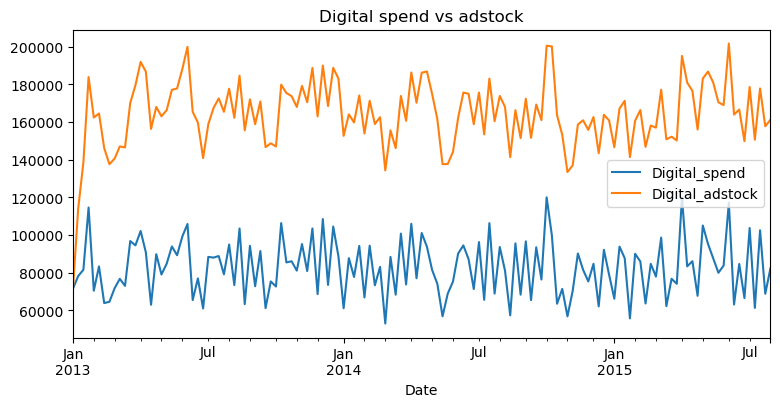

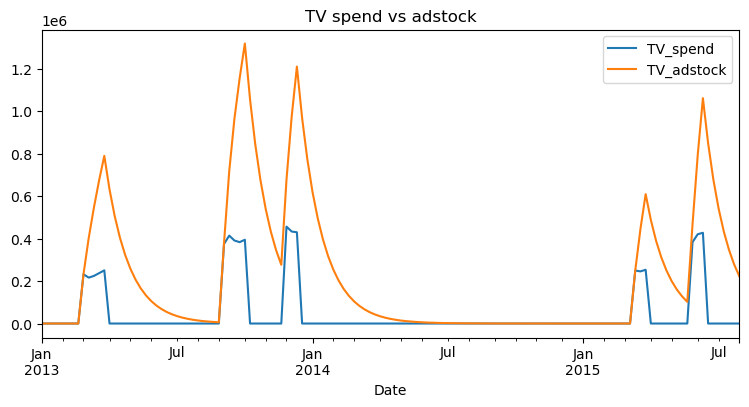

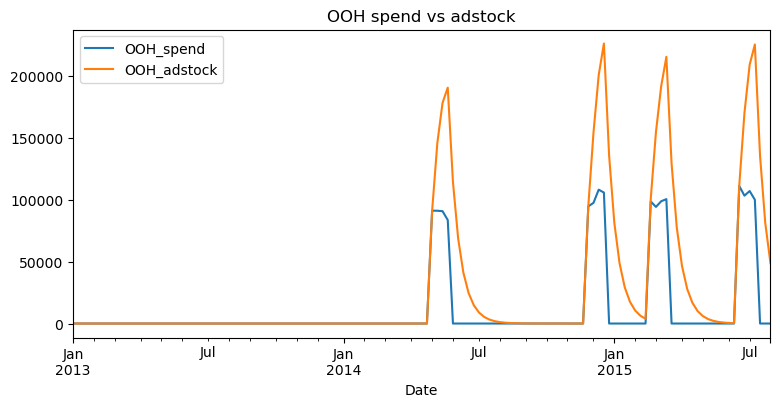

In [54]:
display(weekly_sales_adstock[['Date','Digital_spend','Digital_adstock']].head())

ax = weekly_sales_adstock.plot(x='Date', y=['Digital_spend','Digital_adstock'], figsize=(9,4), title='Digital spend vs adstock')
ax = weekly_sales_adstock.plot(x='Date', y=['TV_spend','TV_adstock'], figsize=(9,4), title='TV spend vs adstock')
ax = weekly_sales_adstock.plot(x='Date', y=['OOH_spend','OOH_adstock'], figsize=(9,4), title='OOH spend vs adstock')


In [55]:
corr_view = weekly_sales_adstock[['Sales','Digital_adstock','TV_adstock','OOH_adstock']].corr().round(3)
corr_view


,Sales,Digital_adstock,TV_adstock,OOH_adstock
Sales,1.000,0.422,0.168,0.149
Digital_adstock,0.422,1.000,0.167,-0.153
TV_adstock,0.168,0.167,1.000,-0.072
OOH_adstock,0.149,-0.153,-0.072,1.000


# Saturation 

Saturation accounts for diminishing returns: As spending increases on a particular media channel, the incremental returns on sales or engagement begin to decrease, creating a saturation effect. This effect is particularly relevant for channels that are already saturated with ads, such as digital and TV, where additional spending yields progressively less impact on customer behavior​.

The formula used is the Hill Funtion

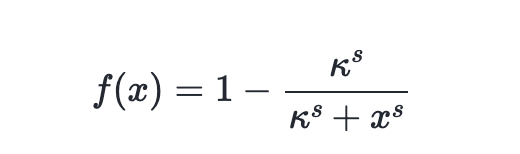

In [56]:
weekly_sales_adstock.columns

Index(['Date', 'Year', 'Month', 'Week_num', 'weekday', 'trend', 'Sales',
       'baseline_sales', 'lift_pct', 'open_rate_store', 'StateHoliday',
       'SchoolHoliday', 'Promo', 'promo_type', 'promo_type2',
       'promo_intensity', 'promo_decay', 'promo_adstock_norm', 'Digital_spend',
       'TV_spend', 'OOH_spend', 'CPM', 'Digital_impressions', 'CTR',
       'Digital_clicks', 'LandingRate', 'Product_page_views', 'holiday_a',
       'holiday_b', 'holiday_c', 'Digital_adstock', 'TV_adstock',
       'OOH_adstock'],
      dtype='object')

In [57]:
from src.saturation import hill_saturation 
# channels 
alpha_map= {
    "Digital": 2.0,
    "TV": 1.6,
    "OOH": 1.2
}

gamma_map = {
    "Digital": weekly_sales_adstock["Digital_adstock"].quantile(0.75),
    "TV":      weekly_sales_adstock["TV_adstock"].quantile(0.75),
    "OOH":     weekly_sales_adstock["OOH_adstock"].quantile(0.75),
}

channels = ["Digital", "TV", "OOH"]

for ch in channels:
    alpha= alpha_map[ch]
    gamma=  gamma_map[ch]
    weekly_sales_adstock[f"{ch}_sat"]= hill_saturation(weekly_sales_adstock[f"{ch}_adstock"],alpha,gamma)

weekly_sales_adstock[["Digital_sat", "TV_sat", "OOH_sat"]].head(20)

,Digital_sat,TV_sat,OOH_sat
0,0.142295,0.000000,0.0
1,0.296500,0.000000,0.0
2,0.383901,0.000000,0.0
3,0.523305,0.000000,0.0
4,0.461213,0.000000,0.0
5,0.467769,0.000000,0.0
6,0.409506,0.000000,0.0
7,0.380726,0.000000,0.0
8,0.390799,0.300895,0.0
9,0.412442,0.508726,0.0


How it’s computed step-by-step

Let’s take one row as an example:

Assume:

- Digital_adstock for that week = 100,000

- γ = 200,000 (75th percentile of all adstocked spends)

- α = 2.0

Plug into the formula:


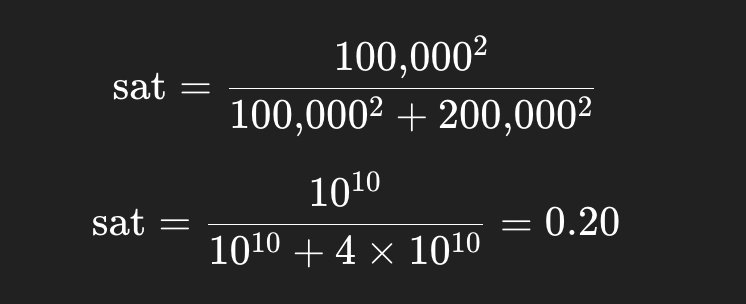


So that week’s Digital_sat = 0.20

→ meaning: at that spend level, you’re using about 20% of the channel’s potential impact.

In [58]:
weekly_sales_adstock.columns

Index(['Date', 'Year', 'Month', 'Week_num', 'weekday', 'trend', 'Sales',
       'baseline_sales', 'lift_pct', 'open_rate_store', 'StateHoliday',
       'SchoolHoliday', 'Promo', 'promo_type', 'promo_type2',
       'promo_intensity', 'promo_decay', 'promo_adstock_norm', 'Digital_spend',
       'TV_spend', 'OOH_spend', 'CPM', 'Digital_impressions', 'CTR',
       'Digital_clicks', 'LandingRate', 'Product_page_views', 'holiday_a',
       'holiday_b', 'holiday_c', 'Digital_adstock', 'TV_adstock',
       'OOH_adstock', 'Digital_sat', 'TV_sat', 'OOH_sat'],
      dtype='object')

https://www.pymc-marketing.io/en/latest/api/generated/pymc_marketing.mmm.transformers.hill_function.html

https://developers.google.com/meridian/docs/advanced-modeling/media-saturation-lagging


In [59]:
weekly_sales_adstock.head(10)

,Date,Year,Month,Week_num,weekday,trend,Sales,baseline_sales,lift_pct,open_rate_store,...,Product_page_views,holiday_a,holiday_b,holiday_c,Digital_adstock,TV_adstock,OOH_adstock,Digital_sat,TV_sat,OOH_sat
0,2013-01-06,2013,1,1,6,1,26129335,3.584752e+07,-0.271098,0.572838,...,55075.497241,1,0,0,71476.013153,0.000000,0.0,0.142295,0.000000,0.0
1,2013-01-13,2013,1,2,6,2,49275222,3.585626e+07,0.374243,0.851890,...,73131.526628,0,0,0,113924.224582,0.000000,0.0,0.296500,0.000000,0.0
2,2013-01-20,2013,1,3,6,3,34377765,3.586500e+07,-0.041468,0.852530,...,42756.078058,0,0,0,138522.437796,0.000000,0.0,0.383901,0.000000,0.0
3,2013-01-27,2013,1,4,6,4,46040169,3.587375e+07,0.283395,0.853940,...,87081.888730,0,0,0,183862.288397,0.000000,0.0,0.523305,0.000000,0.0
4,2013-02-03,2013,2,5,6,5,38466029,3.590751e+07,0.071253,0.854196,...,60492.137175,0,0,0,162359.586298,0.000000,0.0,0.461213,0.000000,0.0
5,2013-02-10,2013,2,6,6,6,49002283,3.591625e+07,0.364349,0.854709,...,79898.184127,0,0,0,164513.359268,0.000000,0.0,0.467769,0.000000,0.0
6,2013-02-17,2013,2,7,6,7,36269664,3.592499e+07,0.009594,0.850609,...,42513.698579,0,0,0,146136.243550,0.000000,0.0,0.409506,0.000000,0.0
7,2013-02-24,2013,2,8,6,8,47701937,3.593374e+07,0.327497,0.856887,...,85618.271631,0,0,0,137594.243409,0.000000,0.0,0.380726,0.000000,0.0
8,2013-03-03,2013,3,9,6,9,38622888,3.596750e+07,0.073827,0.857527,...,57439.151158,0,0,0,140550.345335,232020.371924,0.0,0.390799,0.300895,0.0
9,2013-03-10,2013,3,10,6,10,50405423,3.597624e+07,0.401075,0.855477,...,60444.448365,0,0,0,147025.217213,401635.211132,0.0,0.412442,0.508726,0.0


In [60]:
weekly_sales_adstock.to_csv("../data/processed/weekly_sales_v2.csv", index=False)